In [225]:
import gym
import matplotlib
import numpy as np
import sys
# from rl_envs.grid_world_env import GridWorldEnv
from rl_envs.episodic_grid_world_env import EpisodicGridWorldEnv as GridWorldEnv
from agents.MC_epsilon_greedy import MC_epsilon_greedy as AlgoAgent
from tools.helper import plot_value_function

# rl_envs.grid_world_env import GridWorldEnv

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 



%load_ext autoreload 
# %aimport rl_envs.grid_world_env

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [226]:
def print_actions_policy(policy, env):
    index = 0
    for i in range(env.height):
        print("[", end=" ")
        for j in range(env.width):
            state = (i,j)
            action = np.argmax(policy(state))
            index+=1
            print(env.action_mappings[action], end=" ")
        print("]")
def print_actions_index(agent, env):
    index = 0
    for i in range(env.height):
        print("[", end=" ")
        for j in range(env.width):
            action = agent.get_action(index)
            print(env.action_mappings[action], end=" ")
            index += 1
        print("]")
def print_actions(agent, env):
    for i in range(env.height):
        print("[", end=" ")
        for j in range(env.width):
            action = agent.get_action((i,j))
            print(env.action_mappings[action], end=" ")
        print("]")
def print_by_dict(env, dic):
    for i in range(env.height):
        print("[", end=" ")
        for j in range(env.width):
            print(dic[(i,j)], end=" ")
        print("]")

In [227]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = nA - np.argmax(list(reversed(Q[observation]))) - 1 # find last occurrence of max
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [228]:
def mc_control_epsilon_greedy(env: GridWorldEnv, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.possible_actions))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.possible_actions)
    
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        # state = env.get_random_start()
        state = env.reset()
        # episode_length = 1
        episode_length = 100
        for t in range(episode_length):
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done = env.step(state, action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Find all (state, action) pairs we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            # Find the first occurance of the (state, action) pair in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
        
        # The policy is improved implicitly by changing the Q dictionary
    
    return Q, policy

In [229]:
def get_state_value(Q, policy):
    V = {}
    for state in Q.keys():
        V[state] = sum(policy(state) * Q[state])
    return V

In [230]:
env = GridWorldEnv(5, 5, forbidden_grids=[(1,1),(1,2), (2,2),(3,1),(3,3),(4,1)], target_grids=[(3,2)], forbidden_reward=-1, hit_wall_reward=-1, target_reward=1)
# env = GridWorldEnv(2, 2, forbidden_grids=[(0,1)], target_grids=[(1,1)])

In [231]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=100000, discount_factor=1, epsilon=0.1)
# print(Q)

Episode 100000/100000.

In [232]:
V = get_state_value(Q, policy)
print_by_dict(env,V)


[ -0.2332172796569455 -0.26043081131759566 -0.17905505074307804 -0.15202540115367977 -0.25102699310613336 ]
[ -0.1853794292223269 -0.1648996511935735 -0.18005751913918372 -0.1172321567124986 -0.15879953092710822 ]
[ -0.13756374434258706 -0.11071864518958692 0.885349715537538 -0.07480591325444244 -0.10404098171781423 ]
[ -0.1616415956268431 0.9054986885855498 0.9324119862758261 0.9268848546447614 -0.10385436759332847 ]
[ -0.2398862830458951 0.8287966940240462 0.9419783180606317 0.8565220227512004 -0.1941068991577479 ]


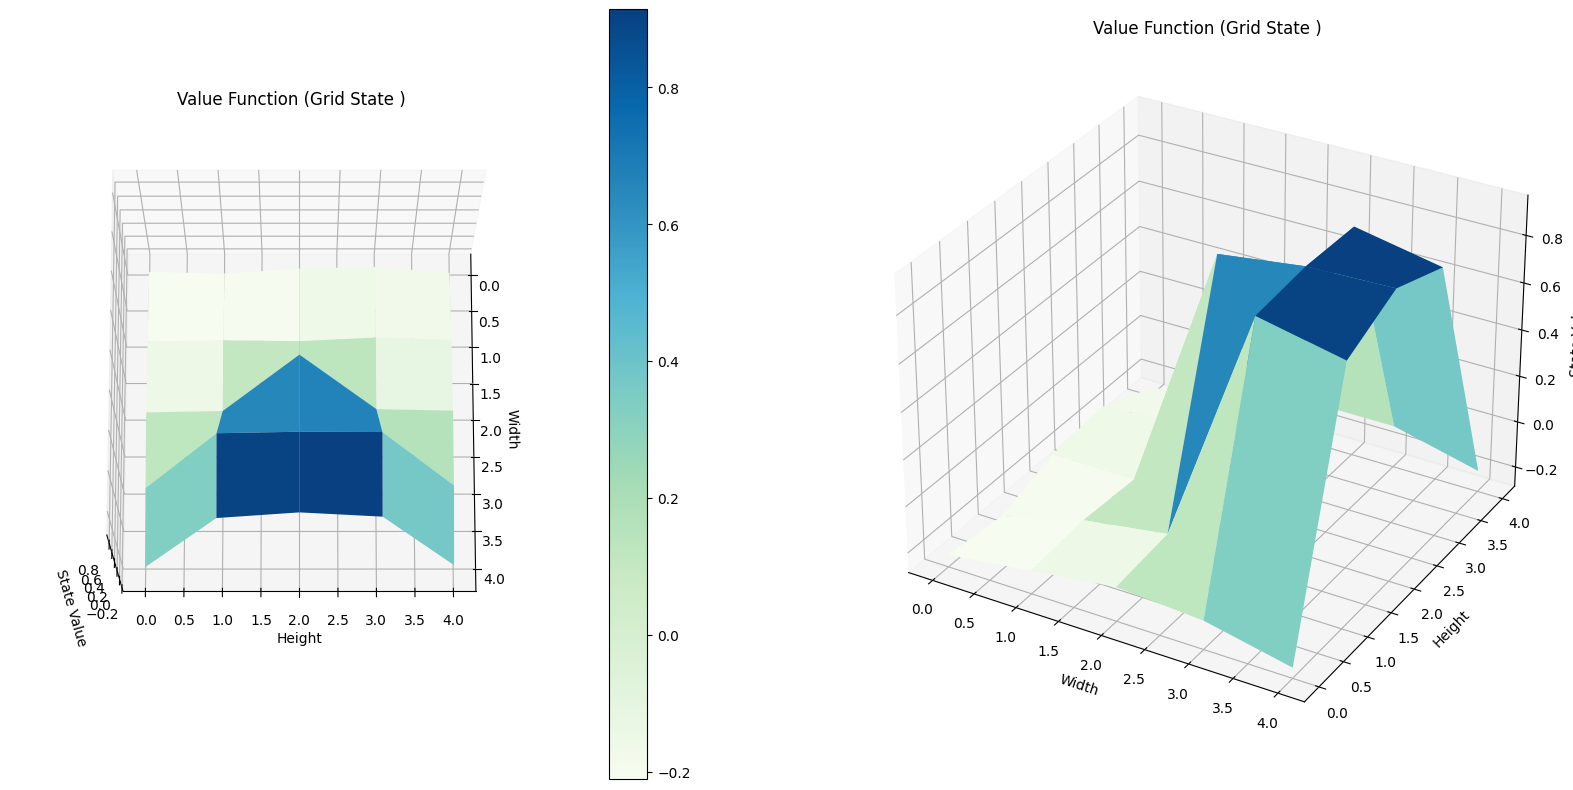

In [233]:
plot_value_function(V)

In [234]:
for i in range(env.height):
    print("[", end=" ")
    for j in range(env.width):
        print(policy((i,j)), end=" ")
    print("]")


[ [0.02 0.02 0.92 0.02 0.02] [0.02 0.92 0.02 0.02 0.02] [0.02 0.92 0.02 0.02 0.02] [0.02 0.02 0.92 0.02 0.02] [0.02 0.02 0.92 0.02 0.02] ]
[ [0.02 0.02 0.92 0.02 0.02] [0.02 0.02 0.92 0.02 0.02] [0.02 0.92 0.02 0.02 0.02] [0.02 0.02 0.92 0.02 0.02] [0.02 0.02 0.92 0.02 0.02] ]
[ [0.02 0.92 0.02 0.02 0.02] [0.02 0.02 0.92 0.02 0.02] [0.02 0.02 0.92 0.02 0.02] [0.02 0.02 0.92 0.02 0.02] [0.02 0.02 0.02 0.92 0.02] ]
[ [0.92 0.02 0.02 0.02 0.02] [0.02 0.92 0.02 0.02 0.02] [0.02 0.02 0.02 0.02 0.92] [0.02 0.02 0.02 0.92 0.02] [0.02 0.02 0.02 0.92 0.02] ]
[ [0.92 0.02 0.02 0.02 0.02] [0.02 0.92 0.02 0.02 0.02] [0.92 0.02 0.02 0.02 0.02] [0.02 0.02 0.02 0.92 0.02] [0.92 0.02 0.02 0.02 0.02] ]


In [235]:
"""
output
"""
print(env)

print_actions_policy(policy, env)

[ 0.00 0.00 0.00 0.00 0.00 ]
[ 0.00 -1.00 -1.00 0.00 0.00 ]
[ 0.00 0.00 -1.00 0.00 0.00 ]
[ 0.00 -1.00 1.00 -1.00 0.00 ]
[ 0.00 -1.00 0.00 0.00 0.00 ]

[  ↓   →   →   ↓   ↓  ]
[  ↓   ↓   →   ↓   ↓  ]
[  →   ↓   ↓   ↓   ←  ]
[  ↑   →   ↺   ←   ←  ]
[  ↑   →   ↑   ←   ↑  ]


In [236]:
"""
[ 0.00 0.00 0.00 0.00 0.00 ]
[ 0.00 -1.00 -1.00 0.00 0.00 ]
[ 0.00 0.00 -1.00 0.00 0.00 ]
[ 0.00 -1.00 1.00 -1.00 0.00 ]
[ 0.00 -1.00 0.00 0.00 0.00 ]


[  →   →   →   ↓   ↓  ]
[  ↓   ↑   →   ↓   ↓  ]
[  →   →   ↓   →   ↓  ]
[  →   →   ↺   ←   ↓  ]
[  ↑   →   ↑   ←   ←  ]

[  →   →   →   ↓   ↓  ]
[  ↓   ↑   ↑   ↓   ↓  ]
[  →   ↺   ↓   →   ↓  ]
[  ↑   →   ↺   ←   ↓  ]
[  ↑   →   ↑   ←   ←  ]

[  →   →   →   →   ↓  ]
[  ↑   ↑   →   ↓   ↓  ]
[  ↑   ←   ↓   →   ↓  ]
[  ↑   →   ↺   ←   ↓  ]
[  ↑   →   ↑   ←   ←  ]
"""

'\n[ 0.00 0.00 0.00 0.00 0.00 ]\n[ 0.00 -1.00 -1.00 0.00 0.00 ]\n[ 0.00 0.00 -1.00 0.00 0.00 ]\n[ 0.00 -1.00 1.00 -1.00 0.00 ]\n[ 0.00 -1.00 0.00 0.00 0.00 ]\n\n\n[  →   →   →   ↓   ↓  ]\n[  ↓   ↑   →   ↓   ↓  ]\n[  →   →   ↓   →   ↓  ]\n[  →   →   ↺   ←   ↓  ]\n[  ↑   →   ↑   ←   ←  ]\n\n[  →   →   →   ↓   ↓  ]\n[  ↓   ↑   ↑   ↓   ↓  ]\n[  →   ↺   ↓   →   ↓  ]\n[  ↑   →   ↺   ←   ↓  ]\n[  ↑   →   ↑   ←   ←  ]\n\n[  →   →   →   →   ↓  ]\n[  ↑   ↑   →   ↓   ↓  ]\n[  ↑   ←   ↓   →   ↓  ]\n[  ↑   →   ↺   ←   ↓  ]\n[  ↑   →   ↑   ←   ←  ]\n'